In [1]:
from glob import glob
import math
from random import uniform
from random import randint
from random import randrange
import logging

from csbdeep.utils import download_and_extract_zip_file
from csbdeep.utils import Path
from elephant.common import run_train
from elephant.common import _get_seg_prediction
from elephant.common import _find_and_push_spots
from elephant.datasets import SegmentationDatasetNumpy
from elephant.losses import SegmentationLoss
from elephant.models import ResUNet
from elephant.models import UNet
from elephant.util import normalize_zero_one
from elephant.util import dilate
from elephant.util.ellipse import ellipse
from elephant.util.ellipsoid import ellipsoid
from elephant.util.scaled_moments import radii_and_rotation
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np
import skimage.measure
from skimage.transform import rotate
from stardist import fill_label_holes
from stardist import random_label_cmap
from stardist.matching import matching, matching_dataset
from tifffile import imread
import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
import torch.utils.data as du
from tqdm import tqdm

from utils import plot_img_label, to_sparse, get_data, plot_stats, run_analysis, remove_small_labels

np.random.seed(42)

## ELEPHANT label generation

In [2]:
def generate_seg(lbl, cr=0.5, min_area=9, is_3d=False):
    if lbl.min() == -1:
        seg = np.zeros(lbl.shape, dtype=np.uint8)
        seg[lbl==0] = 1
    else:
        seg = np.ones(lbl.shape, dtype=np.uint8)
    regions = skimage.measure.regionprops(lbl.clip(0))
    for region in regions:
        if region.minor_axis_length == 0:
            continue
        try:
            radii, rotation = radii_and_rotation(region.moments_central, is_3d)
            if (radii == 0).any():
                raise RuntimeError('all radii should be positive')
        except RuntimeError as e:
            print(str(e))
            continue
        radii *= 2
        factor = 1.0
        while True:
            indices_outer = draw_func(
                region.centroid[:2 + is_3d],
                radii * factor,
                rotation,
                shape=seg.shape,
            )
            if len(indices_outer[0]) < min_area:
                factor *= 1.1
            else:
                break
        factor = 1.0
        while True:
            indices_inner = draw_func(
                region.centroid[:2 + is_3d],
                radii * cr * factor,
                rotation,
                shape=seg.shape,
            )
            if len(indices_inner[0]) < min_area:
                factor *= 1.1
            else:
                break
        indices_inner_p = dilate_func(
            *indices_inner, seg.shape
        )
        seg[indices_outer] = np.where(
            seg[indices_outer] < 2,
            2,
            seg[indices_outer]
        )
        seg[indices_inner_p] = 2
        seg[indices_inner] = 3
    return seg

In [3]:
is_3d = False

if is_3d:
    draw_func = ellipsoid
    dilate_func = dilate.dilate_3d_indices
else:
    draw_func = ellipse
    dilate_func = dilate.dilate_2d_indices

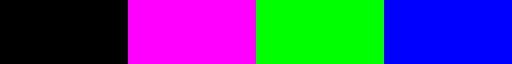

In [4]:
seg_cmap = matplotlib.colors.ListedColormap(np.array([
    [0, 0, 0],
    [1, 0, 1],
    [0, 1, 0],
    [0, 0, 1],
]))
seg_cmap

In [5]:
def get_instance_segmentation(img, models, keep_axials, device, patch_size=None,
                              c_ratio=0.5, p_thresh=0.5,r_min=0, r_max=1e6):
    prediction = _get_seg_prediction(img[None, None], models, keep_axials, device, patch_size)
    spots = []
    _find_and_push_spots(spots,
                         0,
                         prediction[-1], # last channel is the center label
                         c_ratio=c_ratio,
                         p_thresh=p_thresh,
                         r_min=r_min,
                         r_max=r_max,
                        )
    label = np.zeros(img.shape, np.uint16)
    draw_func = ellipsoid if img.ndim == 3 else ellipse
    for i in range(16):
        for ind, spot in enumerate(spots):
            centroid = np.array(spot['pos'][::-1])
            centroid = centroid[-img.ndim:]
            covariance = np.array(spot['covariance'][::-1]).reshape(3, 3)
            covariance = covariance[-img.ndim:, -img.ndim:]
            radii, rotation = np.linalg.eigh(covariance)
            radii = np.sqrt(radii)
            indices = draw_func(
                centroid,
                radii * (1 - 0.05 * i),
                rotation,
                shape=img.shape,
            )
            label[indices] = ind + 1
    # ensure that each spot is labeled at least its center voxcel
    for ind, spot in enumerate(spots):
        centroid = np.array(spot['pos'][::-1])
        centroid = centroid[-img.ndim:]
        indices_center = tuple(int(centroid[i]) for i in range(img.ndim))
        label[indices_center] = ind + 1
    return label

# Data

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

Training data consists of pairs of input image and label instances.

In [6]:
(X_trn, Y_trn), (X_val, Y_val) = get_data()

Files found, nothing to download.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.53it/s]

number of images for training:   447
number of images for validation:  50


## Plot all labels

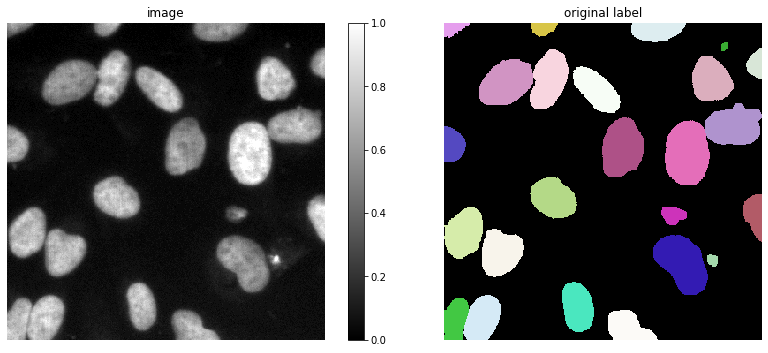

In [36]:
plot_img_label(X_trn[11], Y_trn[11], lbl_title='original label')

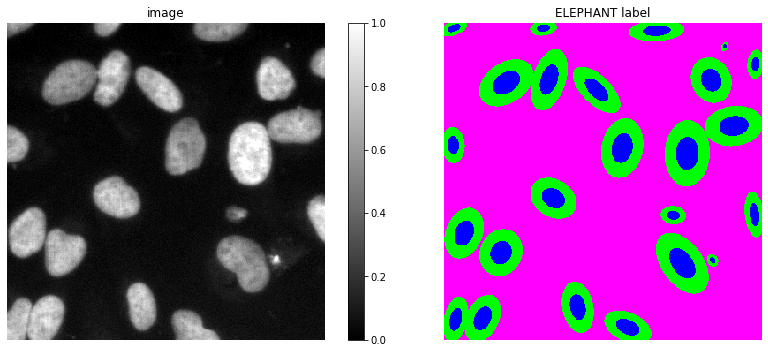

In [35]:
plot_img_label(X_trn[11], generate_seg(Y_trn[11]), lbl_title='ELEPHANT label', lbl_cmap=seg_cmap, vmin=0)

## make sparse annotation

Find the darkest and brightest nuclei

1it [00:00, 42.27it/s]


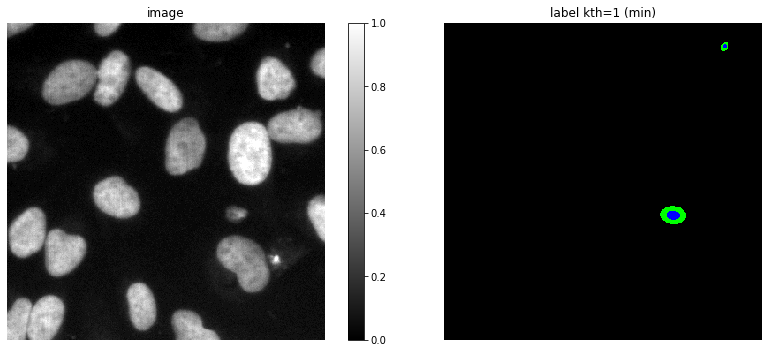

1it [00:00, 85.71it/s]


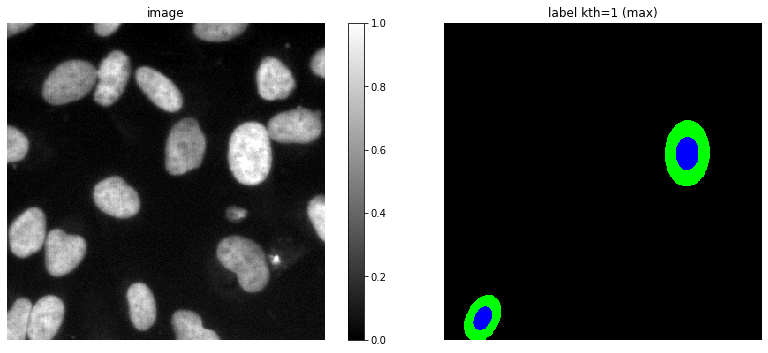

1it [00:00, 76.82it/s]


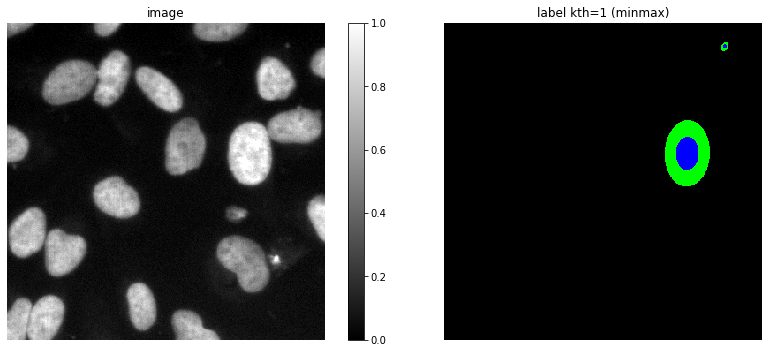

In [17]:
ind = 11
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='min')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (min)')
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='max')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (max)')
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='minmax')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (minmax)')

1it [00:00, 70.99it/s]


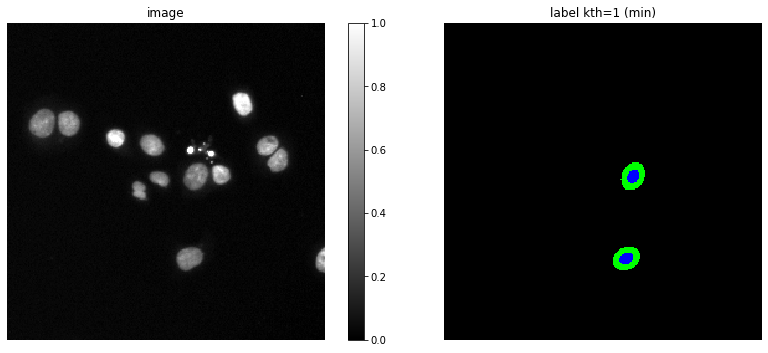

1it [00:00, 141.47it/s]


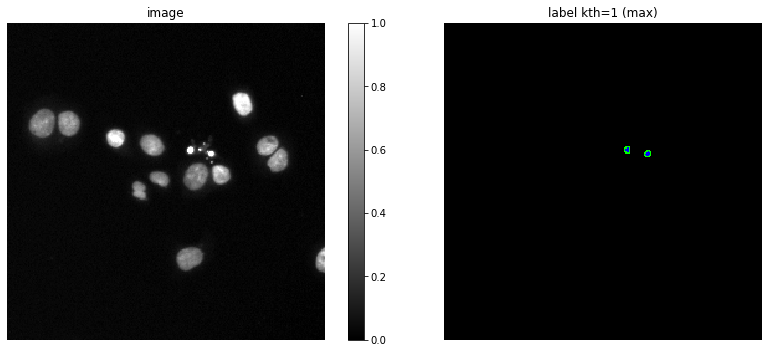

1it [00:00, 128.64it/s]


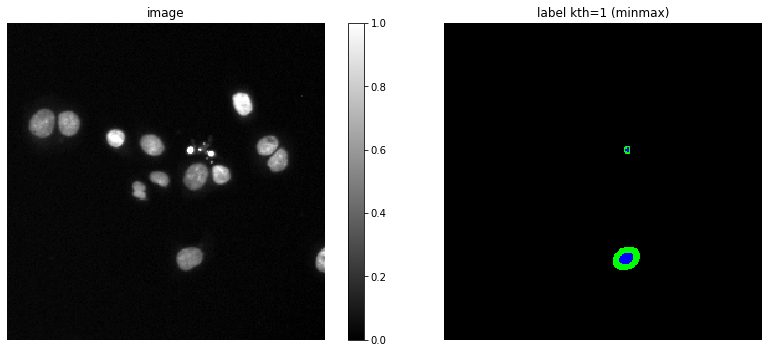

In [9]:
ind = 2
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='min')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (min)')
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='max')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (max)')
plot_img_label(X_trn[ind], generate_seg(to_sparse([X_trn[ind]], [Y_trn[ind]], 1, False, mode='minmax')[0]),
               lbl_cmap=seg_cmap, lbl_title='label kth=1 (minmax)')

In [18]:
def train_model(X_trn, Y_trn, X_val, Y_val, description, **kwargs):
    is_3d = kwargs.get('is_3d', X_trn[0].ndim == 3)
    device = kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
    scale_factor_base = kwargs.get('scale_factor_base', 0.2)
    rotation_angle = kwargs.get('rotation_angle', 45)
    contrast = kwargs.get('contrast', 0.5)
    batch_size = kwargs.get('batch_size', 8)
    crop_size = kwargs.get('crop_size', (224, 224))
    keep_axials = kwargs.get('keep_axials', (True,) * 4)
    class_weights = kwargs.get('class_weights', (1., 10., 10.))
    lr = kwargs.get('lr', 0.001)
    n_epochs = kwargs.get('n_epochs', 100)
    patch_size = kwargs.get('patch_size', None)
    weight_tensor = torch.tensor(class_weights)
    loss_fn = SegmentationLoss(class_weights=weight_tensor, false_weight=1, is_3d=is_3d)
    backbone = kwargs.get('backbone', 'unet')
    model_dir = kwargs.get('model_dir', 'models')
    Path(model_dir).mkdir(exist_ok=True, parents=True)
    model_path = str(Path(model_dir) / f'{backbone}_{description}.pth')
    log_dir = kwargs.get('log_dir', 'logs')
    log_path = kwargs.get('log_path', str(Path(log_dir) / f'{backbone}_{description}'))
    log_interval = kwargs.get('log_interval', 100)
    step_offset = kwargs.get('step_offset', 0)
    epoch_start = kwargs.get('epoch_start', 0)
    increment_from = kwargs.get('increment_from')
    if increment_from is not None:
        increment_from = Path(model_dir) / f'{backbone}_{increment_from}.pth'
        if not increment_from.exists():
            raise ValueError(f'increment_from: {increment_from} does not exist')
    is_generate_seg_trn = kwargs.get('is_generate_seg_trn', True)
    is_generate_seg_val = kwargs.get('is_generate_seg_val', True)
    
    if is_generate_seg_trn:
        Y_trn = list(map(generate_seg, tqdm(Y_trn)))
    if is_generate_seg_val:
        Y_val = list(map(generate_seg, tqdm(Y_val)))
    train_loader = du.DataLoader(
        SegmentationDatasetNumpy(X_trn,
                                 Y_trn,
                                 crop_size=crop_size,
                                 scale_factor_base=scale_factor_base,
                                 rotation_angle=rotation_angle,
                                 contrast=contrast),
        shuffle=True,
        batch_size=batch_size,
    )
    eval_loader = du.DataLoader(
        SegmentationDatasetNumpy(X_val,
                                 Y_val,
                                 is_eval=True),
        shuffle=False,
        batch_size=1,
    )
    checkpoint = torch.load(str(increment_from), map_location=device) if increment_from is not None else None
    if backbone.lower() == 'unet':
        models = [UNet.three_class_segmentation(device=device, is_3d=is_3d, state_dict=checkpoint)]
    elif backbone.lower() == 'resunet':
        models = [ResUNet.three_class_segmentation(device=device, is_3d=is_3d, state_dict=checkpoint)]
    else:
        raise NotImplementedError()
    optimizers = [torch.optim.Adam(model.parameters(), lr=lr) for model in models]
    run_train(
        device, 1,
        models, train_loader, optimizers,
        loss_fn, n_epochs, model_path, False,
        log_interval, log_path, step_offset, epoch_start, eval_loader, patch_size,
        device == 'cpu', True,
    )

In [19]:
def eval_model(X_val, description, **kwargs):
    logging.getLogger().disabled = True
    try:
        device = kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        backbone = kwargs.get('backbone', 'unet')
        model_dir = kwargs.get('model_dir', 'models')
        model_path = str(Path(model_dir) / f'{backbone}_{description}.pth')
        checkpoint = torch.load(model_path, map_location=device)
        if backbone.lower() == 'unet':
            models = [UNet.three_class_segmentation(device=device, is_3d=is_3d, is_eval=True, state_dict=checkpoint)]
        elif backbone.lower() == 'resunet':
            models = [ResUNet.three_class_segmentation(device=device, is_3d=is_3d, is_eval=True, state_dict=checkpoint)]
        else:
            raise NotImplementedError()

        keep_axials = kwargs.get('keep_axials', (True,) * 4)
        device = kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        p_thresh = kwargs.get('p_thresh', 0.8)
        r_min = kwargs.get('r_min', 0)
        r_max = kwargs.get('r_max', 100)
        min_area = kwargs.get('min_area', 0)
        labels = [get_instance_segmentation(x,
                                            models,
                                            keep_axials,
                                            device,
                                            p_thresh=p_thresh,
                                            r_min=r_min,
                                            r_max=r_max)
                  for x in tqdm(X_val)]
        if 0 < min_area:
            for lbl in labels:
                remove_small_labels(lbl, min_area)
    finally:
        logging.getLogger().disabled = False
    return labels

In [20]:
is_train = input('Train models? (existing models can be overwritten) (y/n): ').lower().strip() == 'y'

Train models? (existing models can be overwritten) (y/n): n


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


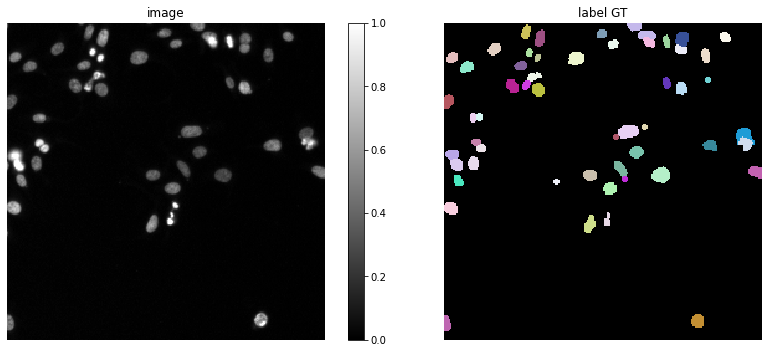

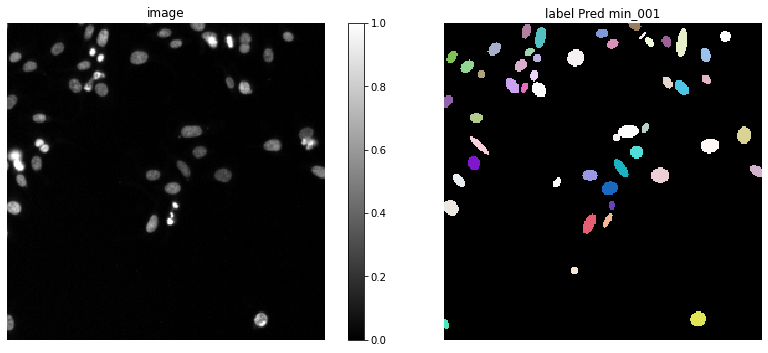

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


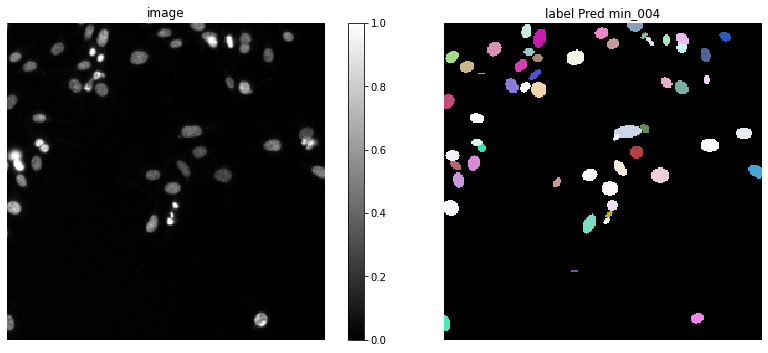

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.34it/s]


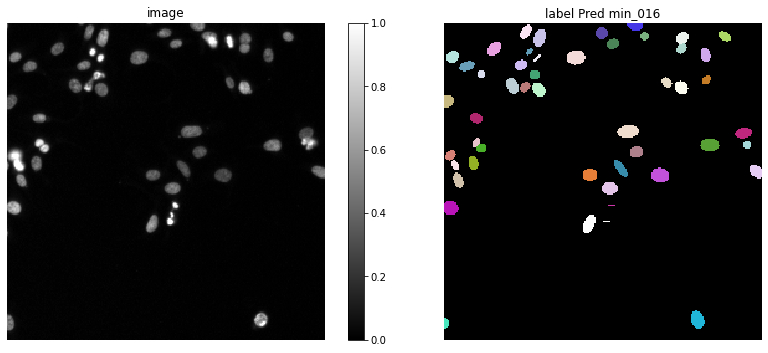

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.52it/s]


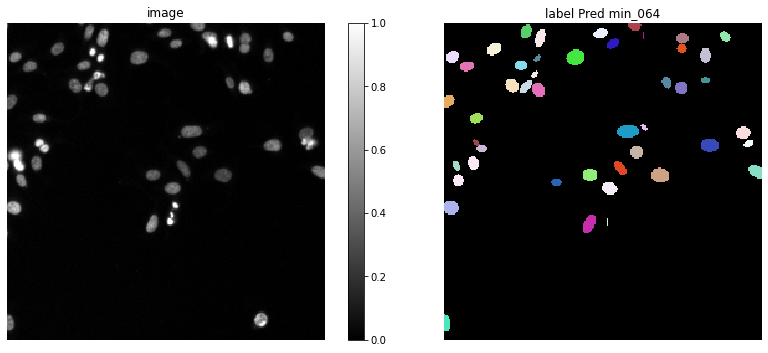

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


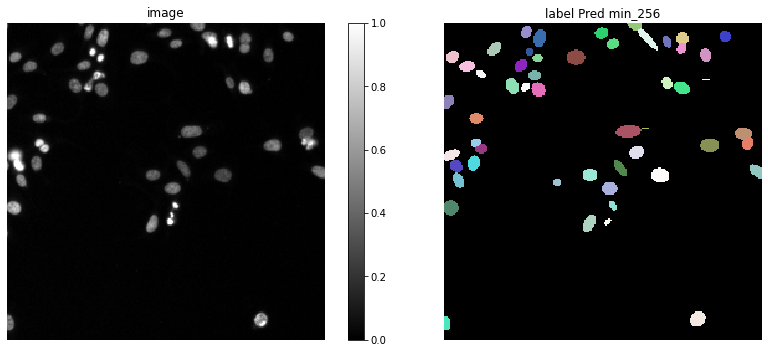

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.60it/s]


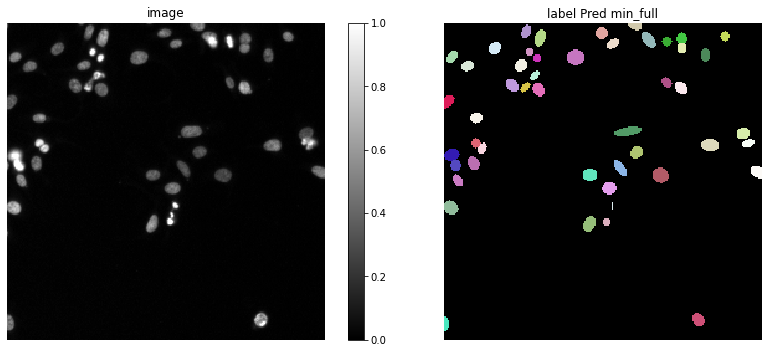

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.91it/s]


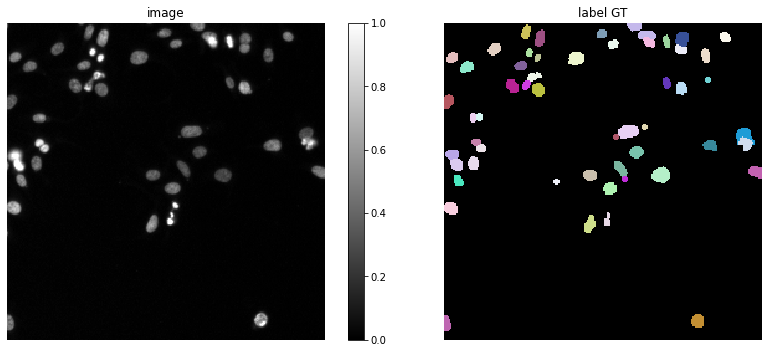

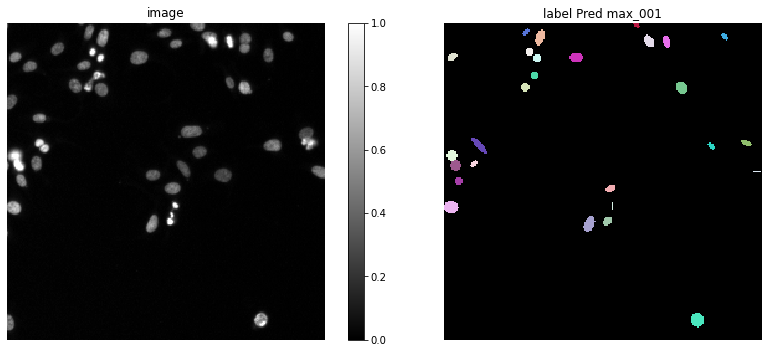

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.97it/s]


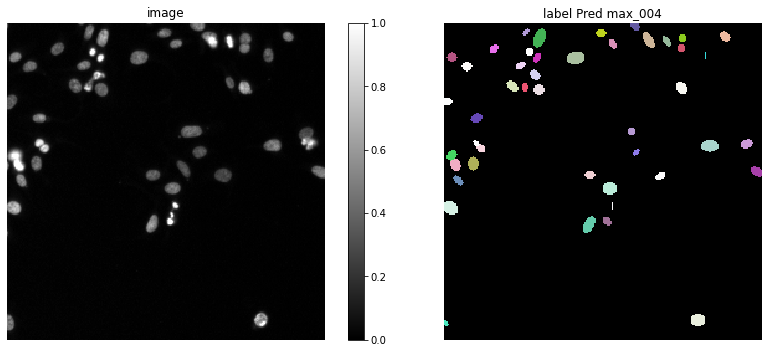

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.19it/s]


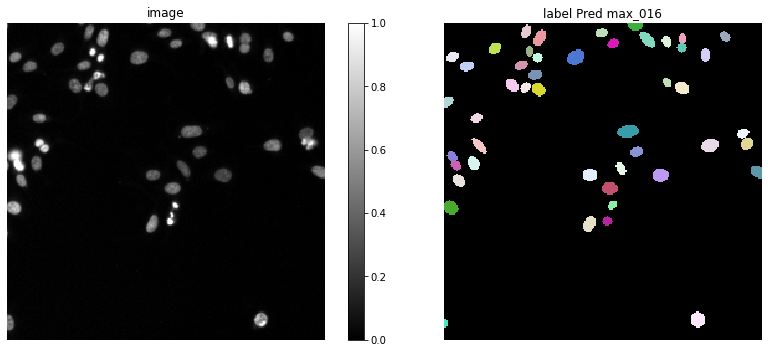

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.11it/s]


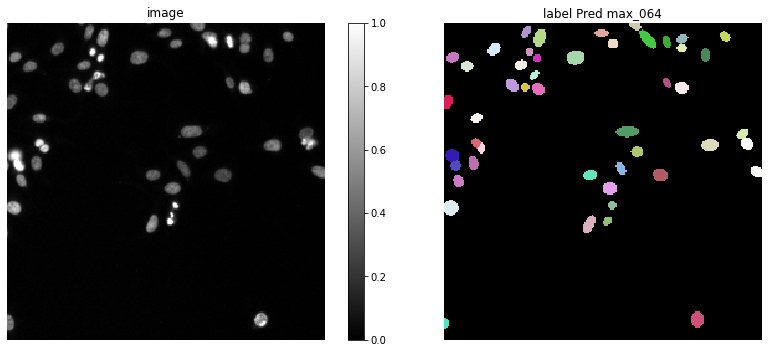

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.72it/s]


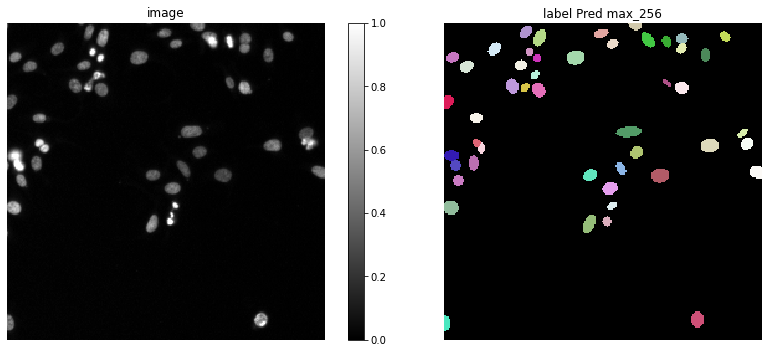

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


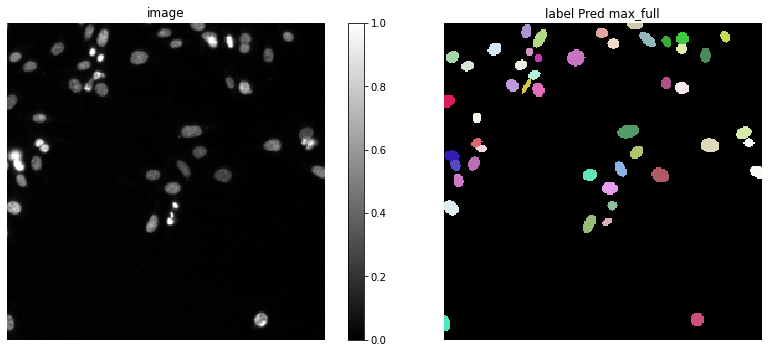

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.51it/s]


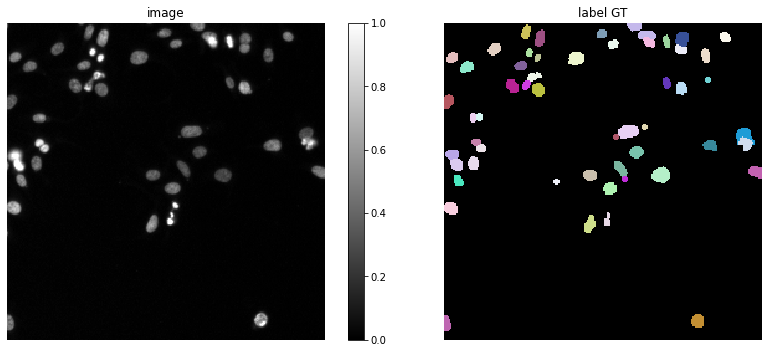

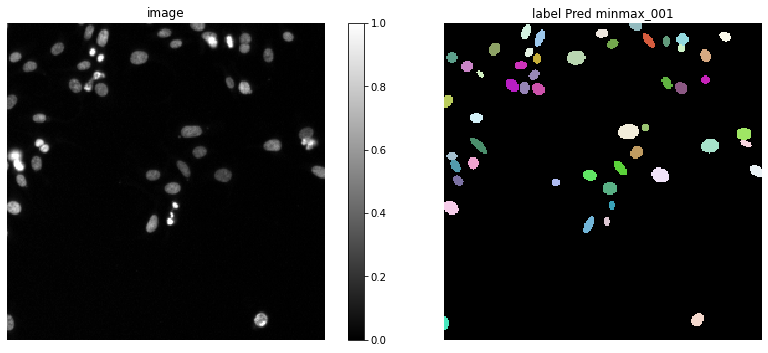

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.24it/s]


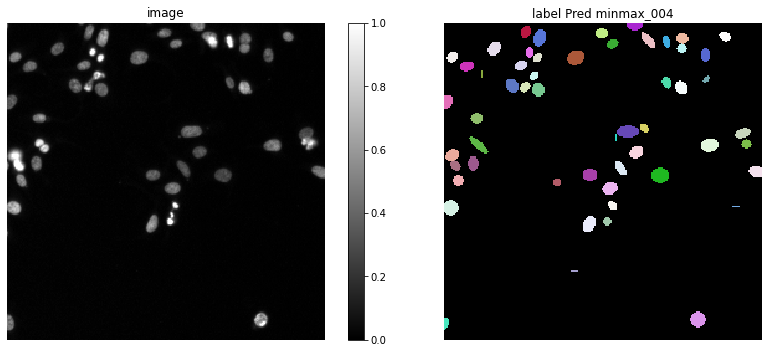

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.44it/s]


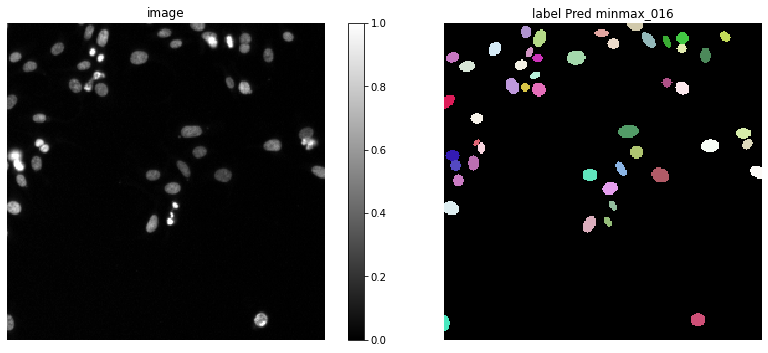

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.73it/s]


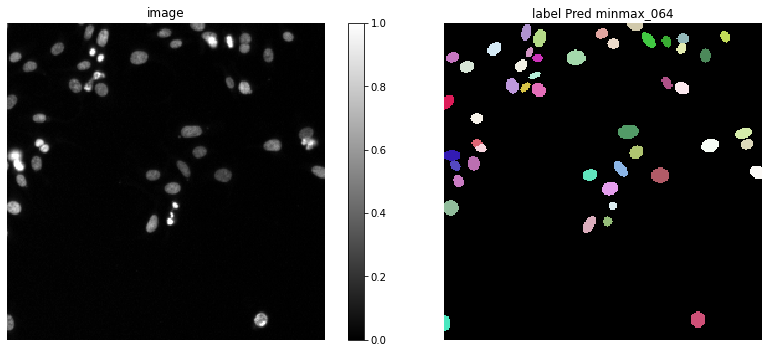

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.45it/s]


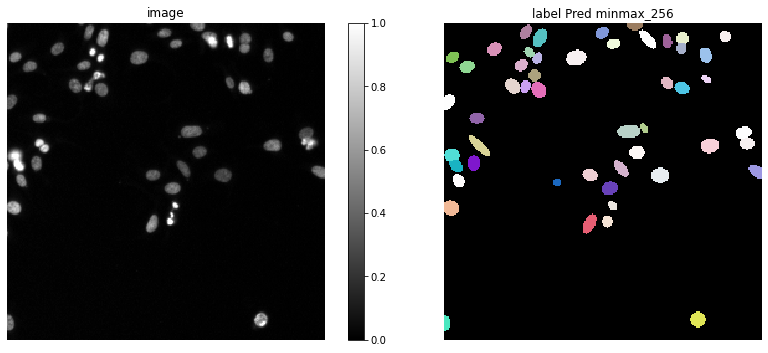

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


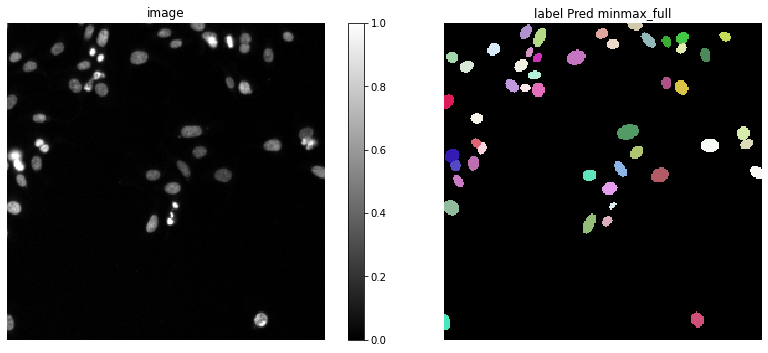

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.01it/s]


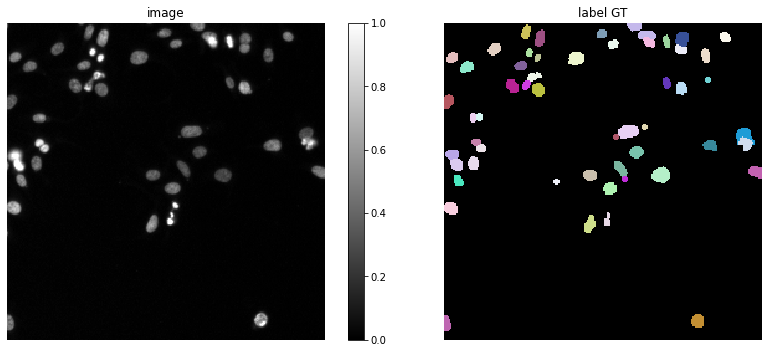

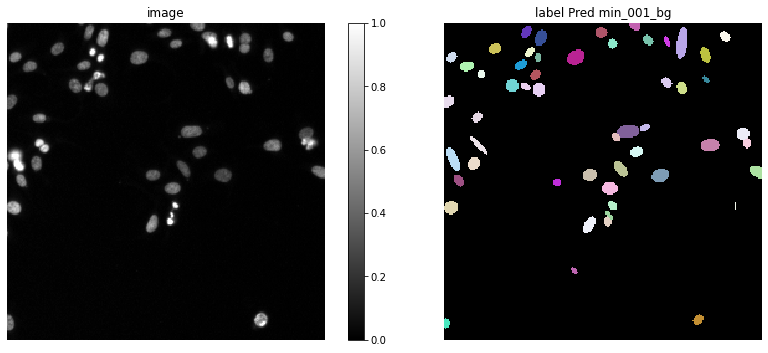

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.32it/s]


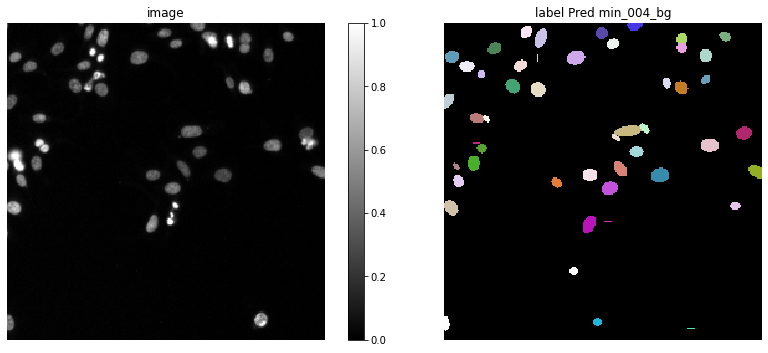

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]


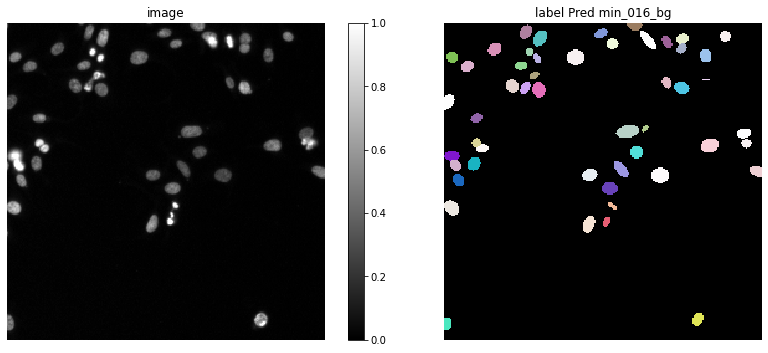

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.22it/s]


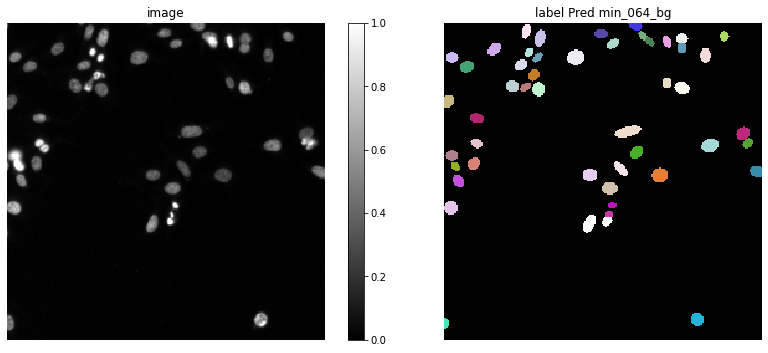

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.98it/s]


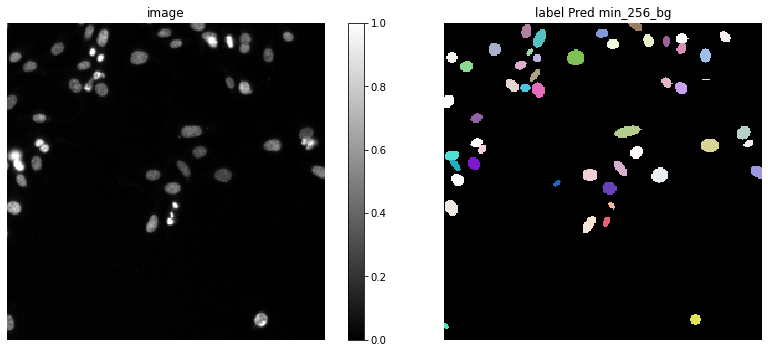

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.94it/s]


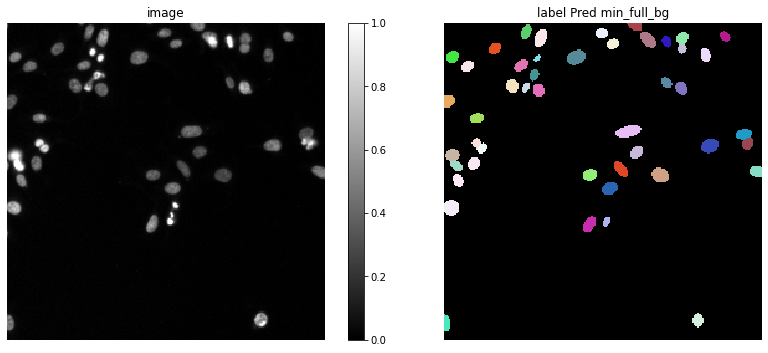

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.62it/s]


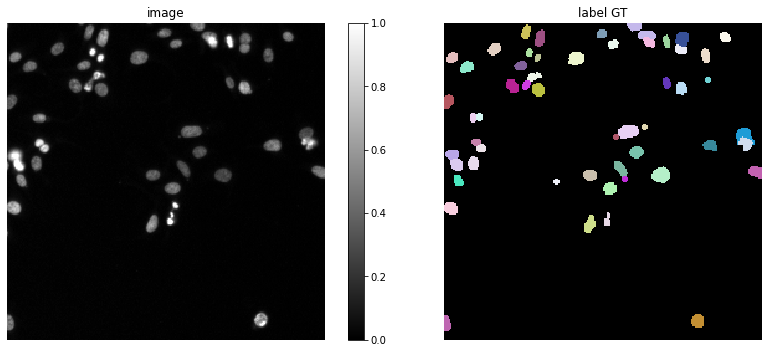

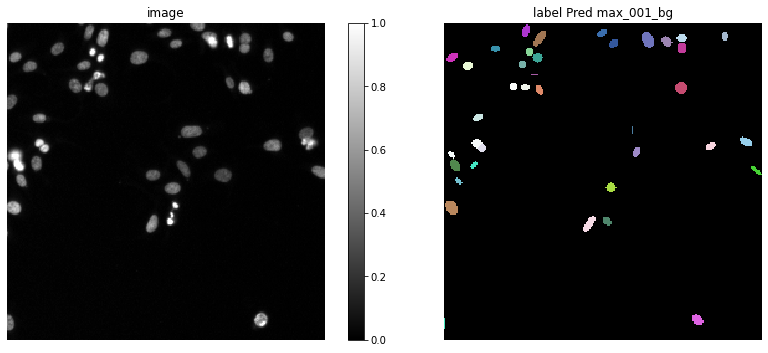

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.51it/s]


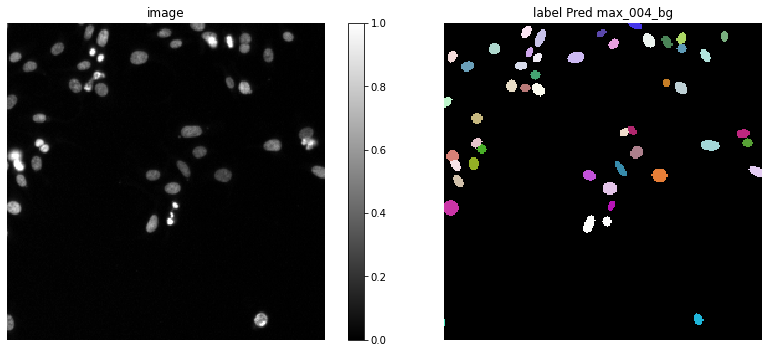

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.01it/s]


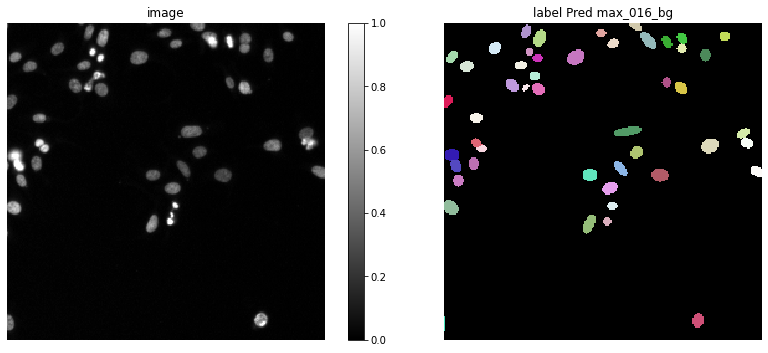

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


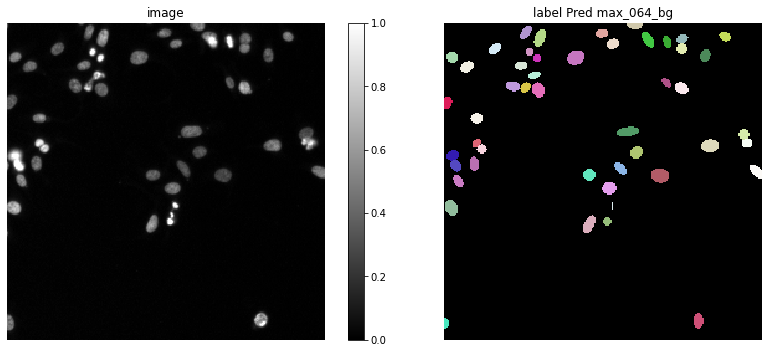

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


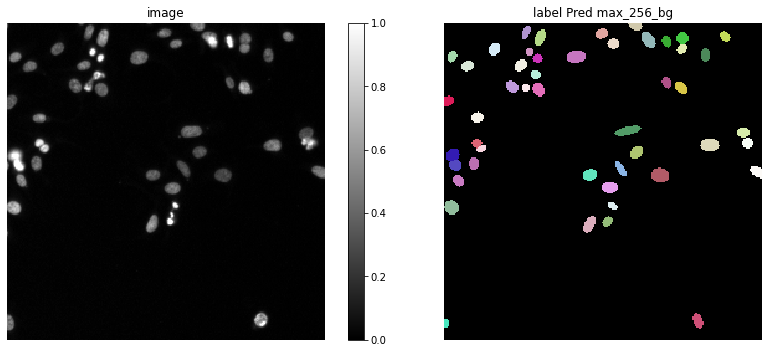

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


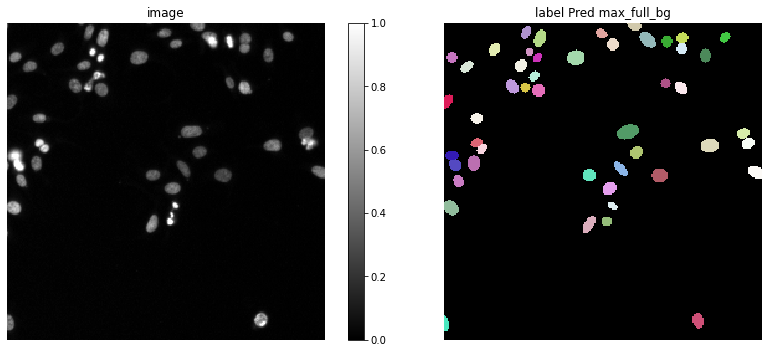

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]


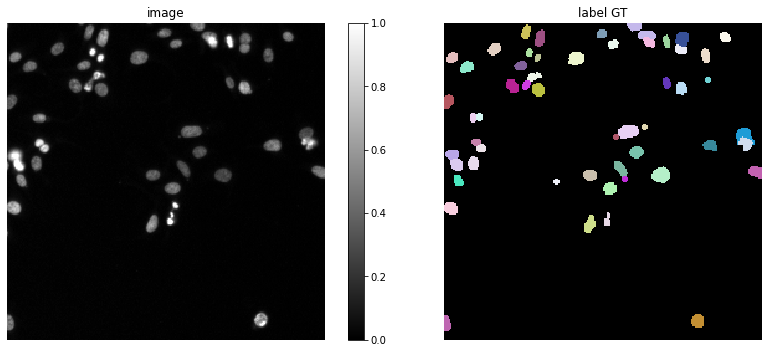

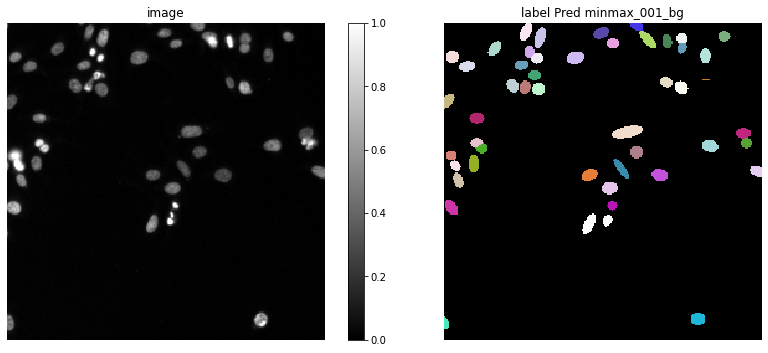

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]


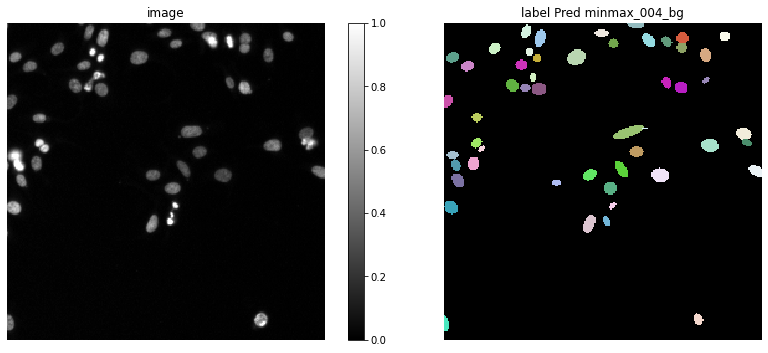

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.78it/s]


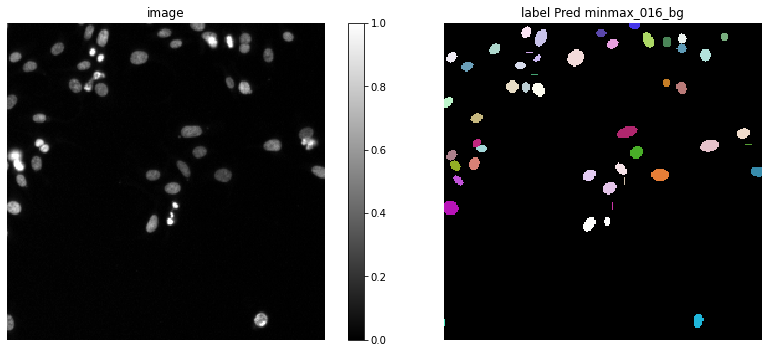

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


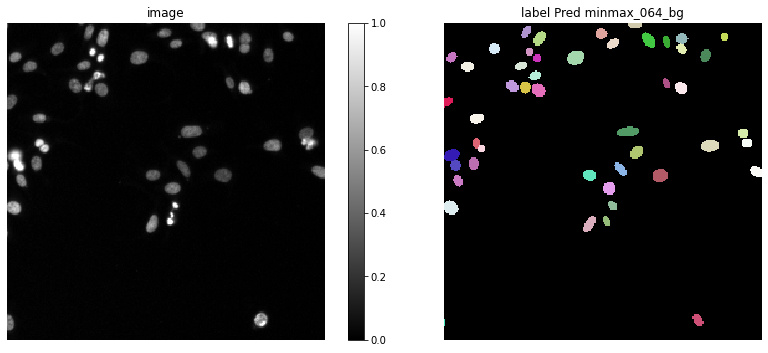

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.48it/s]


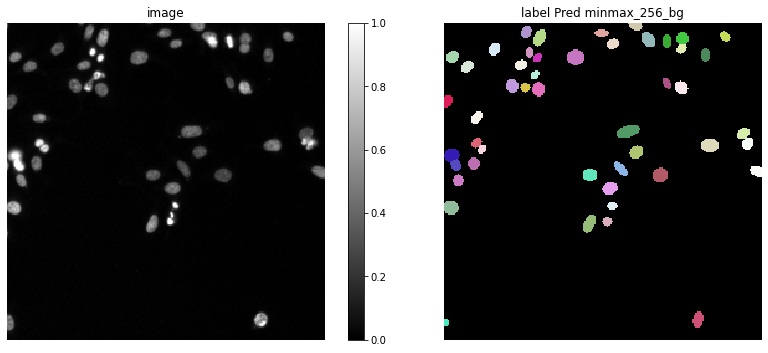

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.54it/s]


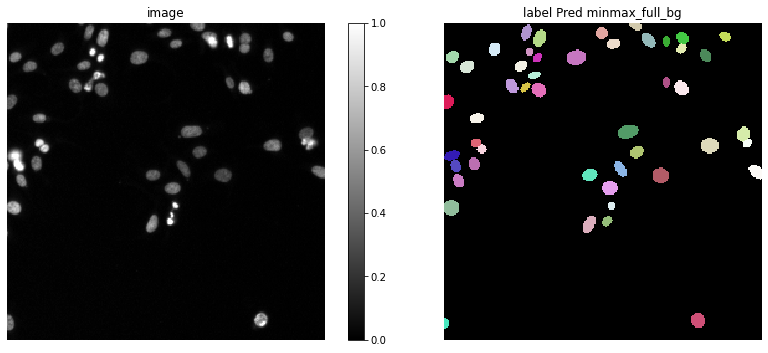

In [22]:
stats_list_dict = {}
for include_bg in (False, True):
    for mode in ('min', 'max', 'minmax'):
        key = f'{mode}{"_bg" if include_bg else ""}'
        stats_list_dict[key] = run_analysis(
            X_trn,
            Y_trn,
            X_val,
            Y_val,
            train_model,
            eval_model,
            mode=mode,
            is_train=is_train,
            include_bg=include_bg,
            model_dir='/workspace/models/DSB2018_224x224_paper03',
            log_dir='/workspace/logs/DSB2018_224x224_paper03',
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


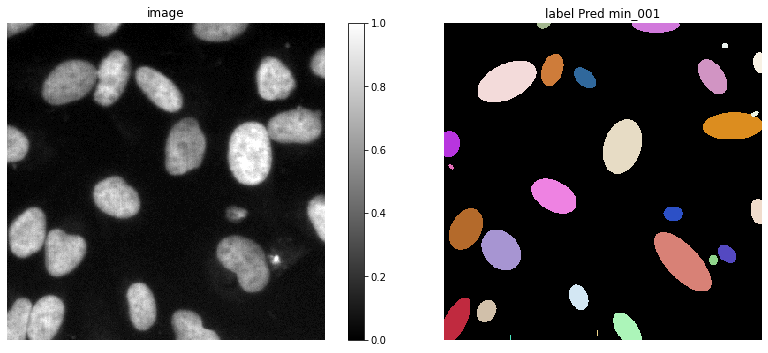

In [32]:
# used for internal seminar
Y_val_pred = eval_model([X_trn[11]], 'min_001', model_dir='/workspace/models/DSB2018_224x224_paper03')
plot_img_label(X_trn[11], Y_val_pred[0], lbl_title=f"label Pred min_001")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


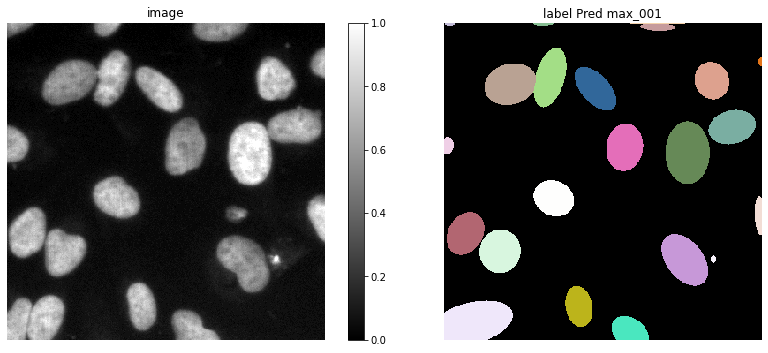

In [33]:
# used for internal seminar
Y_val_pred = eval_model([X_trn[11]], 'max_001', model_dir='/workspace/models/DSB2018_224x224_paper03')
plot_img_label(X_trn[11], Y_val_pred[0], lbl_title=f"label Pred max_001")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


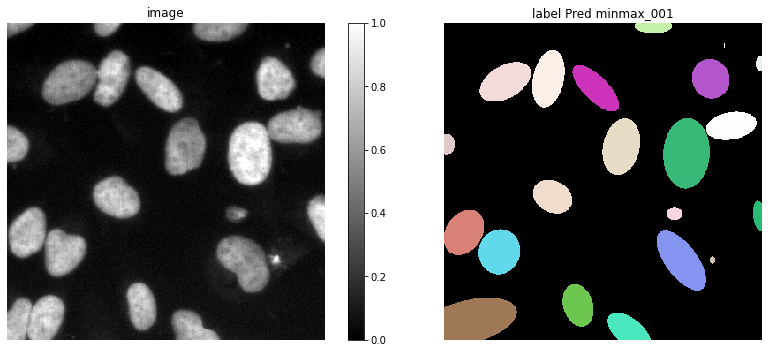

In [34]:
# used for internal seminar
Y_val_pred = eval_model([X_trn[11]], 'minmax_001', model_dir='/workspace/models/DSB2018_224x224_paper03')
plot_img_label(X_trn[11], Y_val_pred[0], lbl_title=f"label Pred minmax_001")

In [30]:
# used for inernal seminar
for s in stats_list_dict['minmax']:
    print(s._asdict()['f1'] )

0.7340403410272406
0.7991098523164071
0.8426943005181348
0.8714196111227264
0.868951194184839
0.8580454928390902


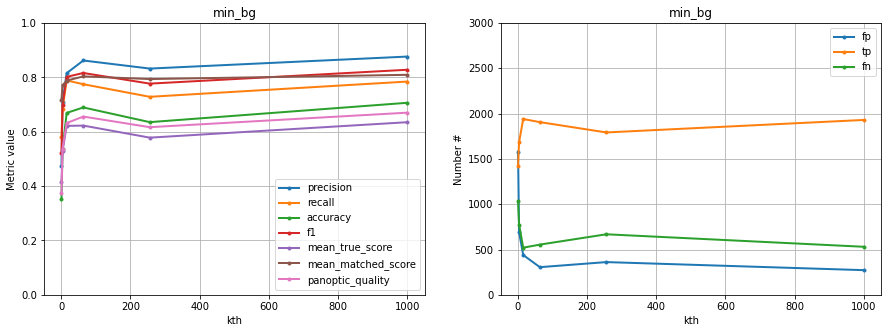

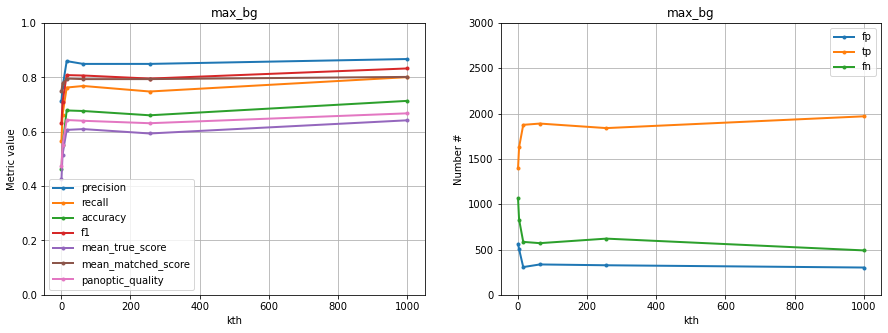

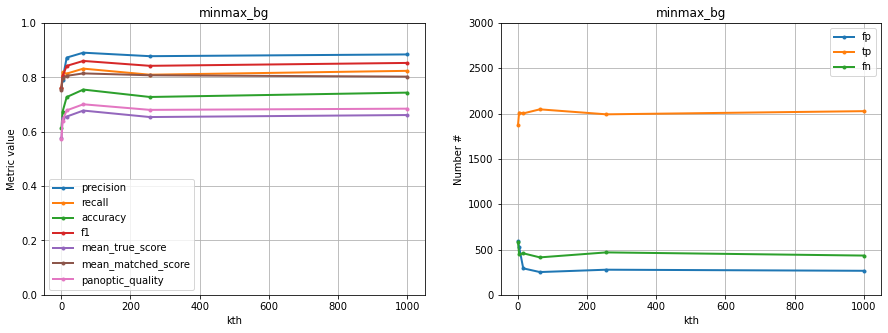

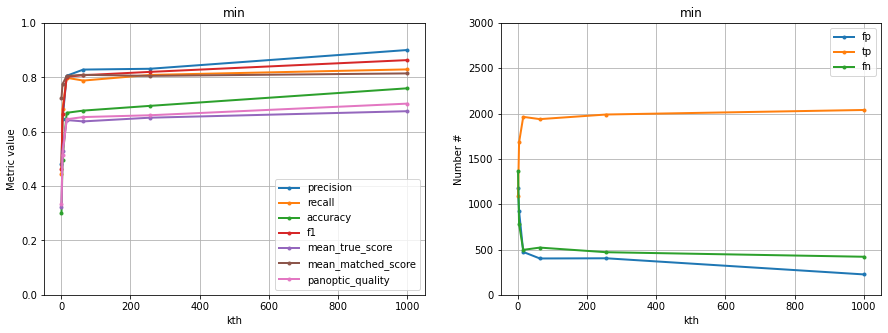

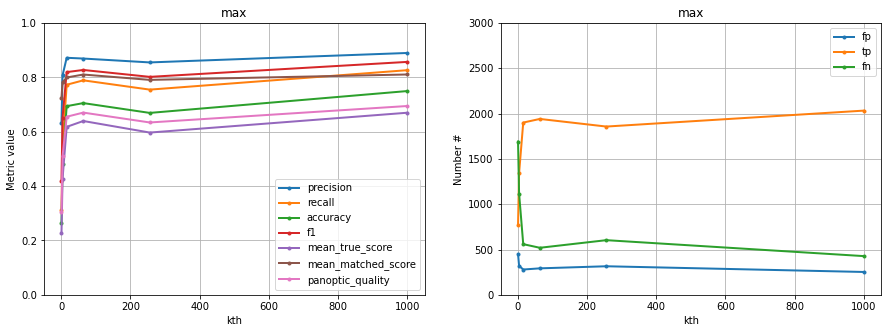

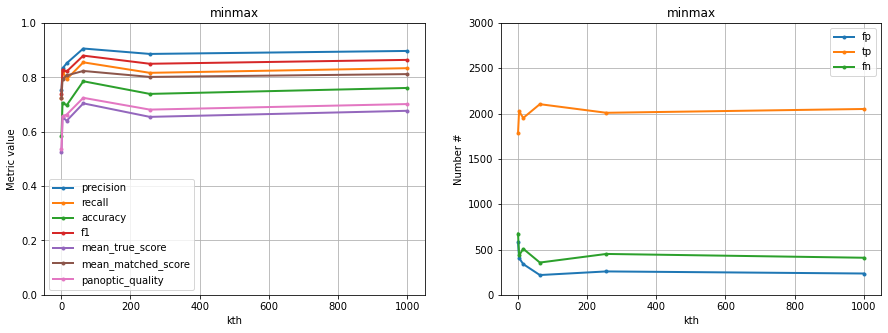

In [14]:
for include_bg in (True, False):
    for mode in ('min', 'max', 'minmax'): 
        key = f'{mode}{"_bg" if include_bg else ""}'
        plot_stats(stats_list_dict[key], key)

In [19]:
dataset = SegmentationDatasetNumpy(X[:5],
                                   list(map(generate_seg, to_sparse(X[:5], Y[:5], 2))),
                                   crop_size=(224, 224),
                                   scale_factor_base=0.2)

5it [00:00, 87.41it/s]
5it [00:00, 1278.36it/s]


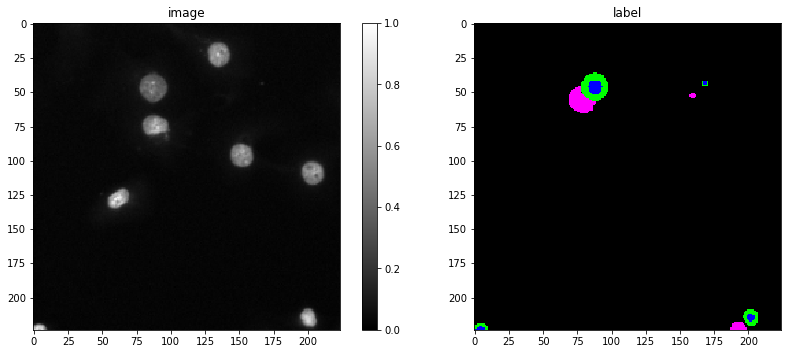

In [20]:
ind = 1
a = dataset[ind]
plot_img_label(a[0][0][0], a[1] + 1, lbl_cmap=seg_cmap, vmin=0, vmax=3)

In [29]:
kth = 'sparse_labels_v3'
description = f'kth{kth:03d}' if isinstance(kth, int) else kth
stats_list_epoch = []
is_generate_seg_trn = True
if isinstance(kth, int):
    Y_trn_s = to_sparse(X_trn, Y_trn, kth=kth, include_bg=True, mode='minmax')
elif kth == 'full':
    Y_trn_s = Y_trn
else:
    p_labels = list(natsorted(Path(f'/workspace/datasets/dsb2018_256x256/{kth}/').iterdir()))
    Y_trn_s = [skimage.io.imread(p) for p in p_labels] * 3
    X_trn = [skimage.io.imread(str(p).replace(f'dsb2018_256x256/{kth}', 'dsb2018/train/images'))
             for p in p_labels] * 3
    X_trn = [normalize_zero_one(x.astype(np.float32)) for x in tqdm(X_trn)]
    for i in range(len(p_labels)):
        assert X_trn[i].shape == Y_trn_s[i].shape
    is_generate_seg_trn = False
    

model_dir = f'/workspace/models/DSB2018_224x224_{description}_epoch'
Path(model_dir).mkdir(exist_ok=True)
log_path = f'/workspace/logs/DSB2018_224x224_{description}_epoch'
for epoch in range(100):
    description = f'epoch_{epoch:03d}'
    train_model(
        X_trn,
        Y_trn_s,
        X_val,
        Y_val,
        description,
        model_dir=model_dir,
        log_path=log_path,
        increment_from=f'epoch_{epoch-1:03d}' if 0 < epoch else None,
        n_epochs=1,
        step_offset=len(X_trn)*epoch,
        epoch_start=epoch,
        is_generate_seg_trn=is_generate_seg_trn,
    )
    logging.getLogger().disabled = True
    Y_val_pred = eval_model(X_val, description, model_dir=model_dir)
    logging.getLogger().disabled = False
    stats_list_epoch.append(matching_dataset(Y_val, Y_val_pred, thresh=0.5, show_progress=False))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:05<00:00, 12.03it/s]
DistributedDataParallel is not used.
Train Epoch: 0 [390/390 (100%)]	Loss: 0.507587	NLL Loss: 1.119528	Center Dice Loss: 0.474340	Smooth Loss: 0.061877
Eval Epoch: 0 	Loss: 0.420712
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.06it/s]
DistributedDataParallel is not used.
Train Epoch: 1 [390/390 (100%)]	Loss: 0.372833	NLL Loss: 0.692253	Center Dice Loss: 0.375678	Smooth Loss: 0.039190
Eval Epoch: 1 	Loss: 0.457856
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 13.44it/s]
DistributedDataParallel 

Eval Epoch: 13 	Loss: 0.288403
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.04it/s]
DistributedDataParallel is not used.
Train Epoch: 14 [390/390 (100%)]	Loss: 0.251554	NLL Loss: 0.438987	Center Dice Loss: 0.260427	Smooth Loss: 0.019758
Eval Epoch: 14 	Loss: 0.245120
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 13.93it/s]
DistributedDataParallel is not used.
Train Epoch: 15 [390/390 (100%)]	Loss: 0.261330	NLL Loss: 0.453824	Center Dice Loss: 0.271251	Smooth Loss: 0.019233
Eval Epoch: 15 	Loss: 0.243024
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 

Eval Epoch: 27 	Loss: 0.227546
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:05<00:00, 11.40it/s]
DistributedDataParallel is not used.
Train Epoch: 28 [390/390 (100%)]	Loss: 0.206689	NLL Loss: 0.348786	Center Dice Loss: 0.216214	Smooth Loss: 0.016964
Eval Epoch: 28 	Loss: 0.159497
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.01it/s]
DistributedDataParallel is not used.
Train Epoch: 29 [390/390 (100%)]	Loss: 0.221586	NLL Loss: 0.386391	Center Dice Loss: 0.229532	Smooth Loss: 0.017051
Eval Epoch: 29 	Loss: 0.232533
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 

Eval Epoch: 41 	Loss: 0.207522
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.41it/s]
DistributedDataParallel is not used.
Train Epoch: 42 [390/390 (100%)]	Loss: 0.185655	NLL Loss: 0.285122	Center Dice Loss: 0.199721	Smooth Loss: 0.015857
Eval Epoch: 42 	Loss: 0.197172
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.47it/s]
DistributedDataParallel is not used.
Train Epoch: 43 [390/390 (100%)]	Loss: 0.187508	NLL Loss: 0.292214	Center Dice Loss: 0.200914	Smooth Loss: 0.015770
Eval Epoch: 43 	Loss: 0.162756
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 

Eval Epoch: 55 	Loss: 0.160296
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.01it/s]
DistributedDataParallel is not used.
Train Epoch: 56 [390/390 (100%)]	Loss: 0.168233	NLL Loss: 0.252201	Center Dice Loss: 0.182011	Smooth Loss: 0.015374
Eval Epoch: 56 	Loss: 0.184827
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.01it/s]
DistributedDataParallel is not used.
Train Epoch: 57 [390/390 (100%)]	Loss: 0.172074	NLL Loss: 0.255480	Center Dice Loss: 0.186722	Smooth Loss: 0.015433
Eval Epoch: 57 	Loss: 0.152493
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:05<00:00, 

Eval Epoch: 69 	Loss: 0.324730
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.23it/s]
DistributedDataParallel is not used.
Train Epoch: 70 [390/390 (100%)]	Loss: 0.164303	NLL Loss: 0.255127	Center Dice Loss: 0.176037	Smooth Loss: 0.014812
Eval Epoch: 70 	Loss: 0.136544
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]
DistributedDataParallel is not used.
Train Epoch: 71 [390/390 (100%)]	Loss: 0.167793	NLL Loss: 0.266166	Center Dice Loss: 0.178636	Smooth Loss: 0.015202
Eval Epoch: 71 	Loss: 0.209896
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 

Eval Epoch: 83 	Loss: 0.132668
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.01it/s]
DistributedDataParallel is not used.
Train Epoch: 84 [390/390 (100%)]	Loss: 0.155687	NLL Loss: 0.240067	Center Dice Loss: 0.166908	Smooth Loss: 0.015202
Eval Epoch: 84 	Loss: 0.215560
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.12it/s]
DistributedDataParallel is not used.
Train Epoch: 85 [390/390 (100%)]	Loss: 0.142449	NLL Loss: 0.207617	Center Dice Loss: 0.154820	Smooth Loss: 0.015424
Eval Epoch: 85 	Loss: 0.120486
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 

Eval Epoch: 97 	Loss: 0.177198
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:05<00:00, 11.64it/s]
DistributedDataParallel is not used.
Train Epoch: 98 [390/390 (100%)]	Loss: 0.141349	NLL Loss: 0.215975	Center Dice Loss: 0.151736	Smooth Loss: 0.014793
Eval Epoch: 98 	Loss: 0.177146
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.07it/s]
DistributedDataParallel is not used.
Train Epoch: 99 [390/390 (100%)]	Loss: 0.144722	NLL Loss: 0.206824	Center Dice Loss: 0.158342	Smooth Loss: 0.014519
Eval Epoch: 99 	Loss: 0.176262
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00, 

## kth=1

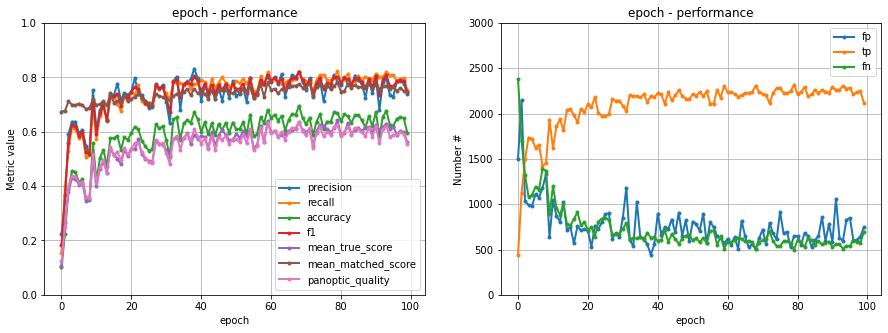

In [51]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

## kth=4

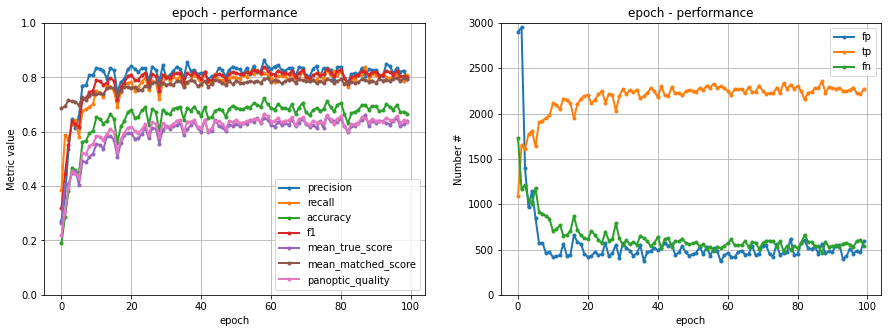

In [55]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

## kth=16

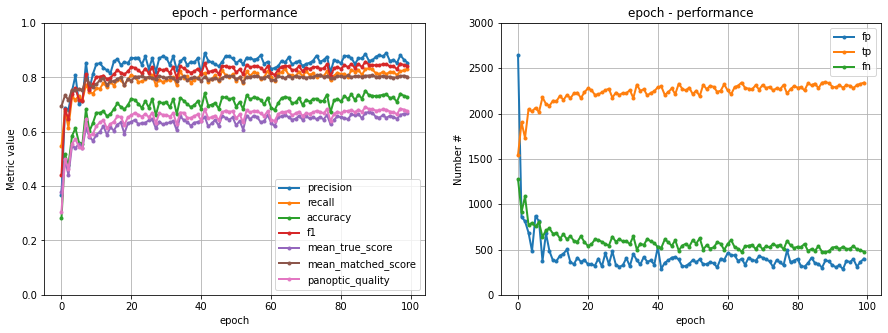

In [57]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

## kth=64

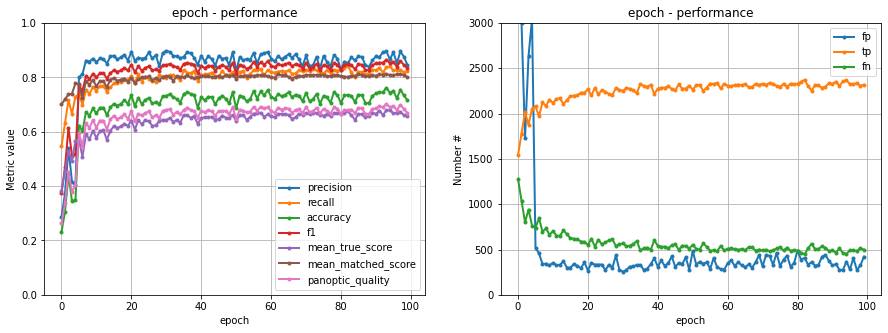

In [59]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

## kth=256

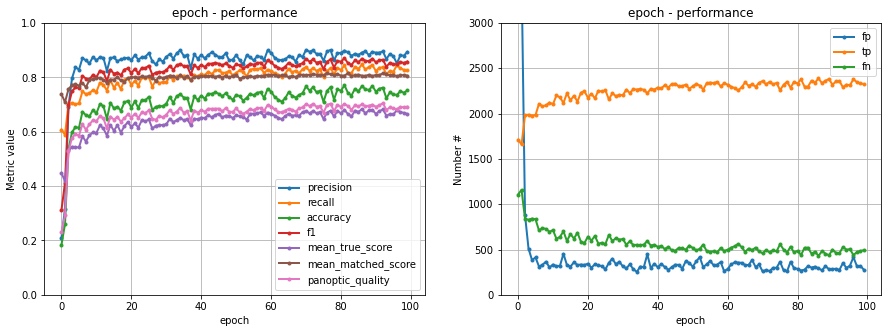

In [63]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

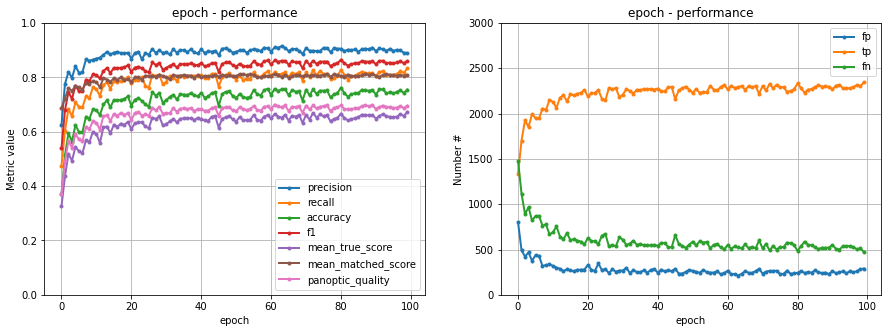

In [69]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

## Manual annotation v1

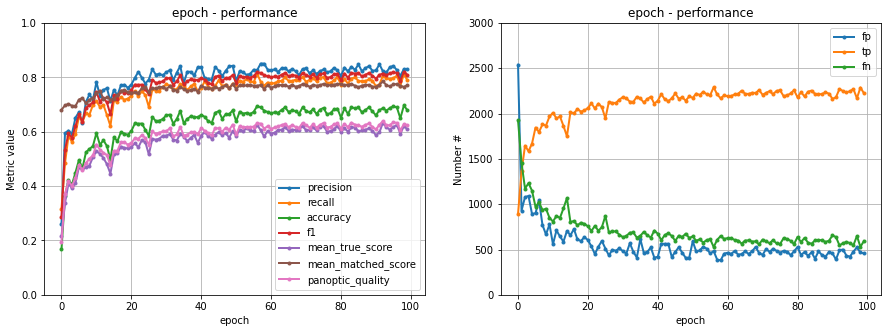

In [41]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

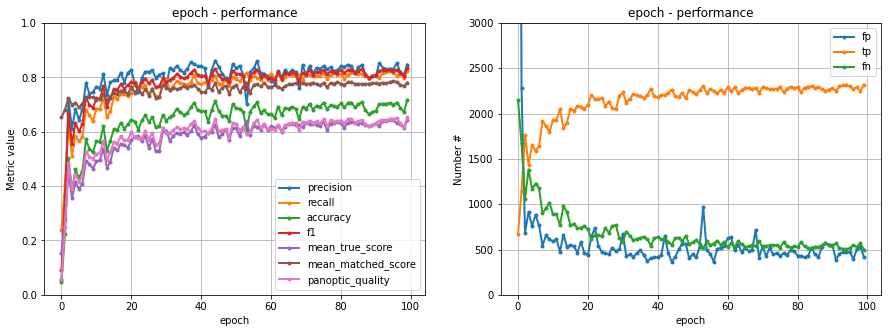

In [44]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

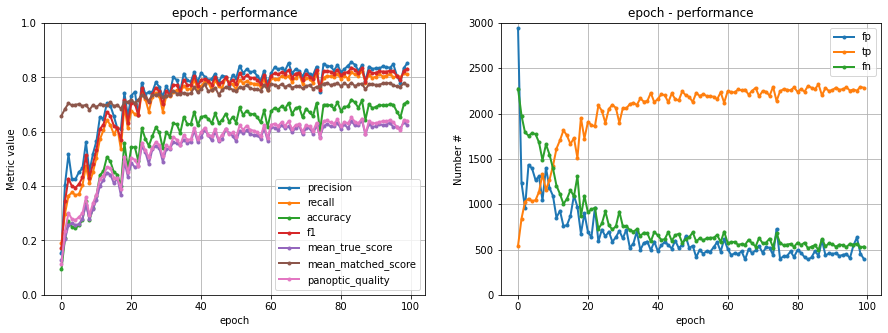

In [30]:
plot_stats(stats_list_epoch, 'epoch - performance', data_points=list(range(100)), xlabel='epoch')

In [92]:
from tifffile import imsave
X_org = list(map(imread, X_files))
for i, ind in tqdm(enumerate(ind_train)):
    assert np.array_equal(normalize_zero_one(X_org[ind].astype(np.float32)), X_trn[i])
    h, w = X_org[ind].shape
    x_path = Path(X_files[ind].replace('train', 'train_256x256'))
    x_path.parent.mkdir(exist_ok=True, parents=True)
    y_path = Path(Y_files[ind].replace('train', 'train_256x256'))
    y_path.parent.mkdir(exist_ok=True, parents=True)
    imsave(x_path, X_org[ind][(h-256)//2:(h-256)//2+256, (w-256)//2:(w-256)//2+256])
    imsave(y_path, Y[ind][(h-256)//2:(h-256)//2+256, (w-256)//2:(w-256)//2+256])

380it [00:01, 230.55it/s]
